<a href="https://colab.research.google.com/github/lbonilla/TEC_AD_HM1_TreesDecision/blob/main/src_base/base_attack_detection_kdd99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data loading

In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [3]:
#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

#describe the dataset
#transform nominal features using a one hot vector encoding
pd_data_frame.describe()

# Determinar si se puede usar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch
print(f"Usando dispositivo: {device}")


2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
/root/.keras/datasets/kddcup.data_10_percent.gz
Usando dispositivo: cuda


# Preprocessing and  Dummy encoding transformation

Attacks fall into four main categories:






1.   DOS: denial-of-service, e.g. syn flood;
2.   R2L: unauthorized access from a remote machine, e.g. guessing password;

3. U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;

4. probing: surveillance and other probing, e.g., port scanning.


It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data.  This makes the task more realistic.  Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants.  The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.

Neptune is the most frequent attack in the dataset, consisting in a type of denial-of-service (DoS) attack overwhelming systems with SYN requests (ynchronize request, is a type of network packet used in the TCP handshake to initiate a connection between a client and a server).

**In this work we will focus in the detection of backdrop attacks**.

In [4]:
# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True,axis=1)

# Checkng for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace = True)
print(pd_data_frame.describe())



            duration     src_bytes     dst_bytes           land  \
count  145586.000000  1.455860e+05  1.455860e+05  145586.000000   
mean      132.025181  7.995700e+03  2.859780e+03       0.000137   
std      1224.157053  1.820383e+06  6.080979e+04       0.011720   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  0.000000e+00  0.000000e+00       0.000000   
50%         0.000000  1.470000e+02  1.050000e+02       0.000000   
75%         0.000000  2.880000e+02  1.164750e+03       0.000000   
max     58329.000000  6.933756e+08  5.155468e+06       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   145586.000000  145586.000000  145586.000000      145586.000000   
mean         0.020201       0.000048       0.100174           0.000515   
std          0.239368       0.010150       1.426798           0.028585   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000     

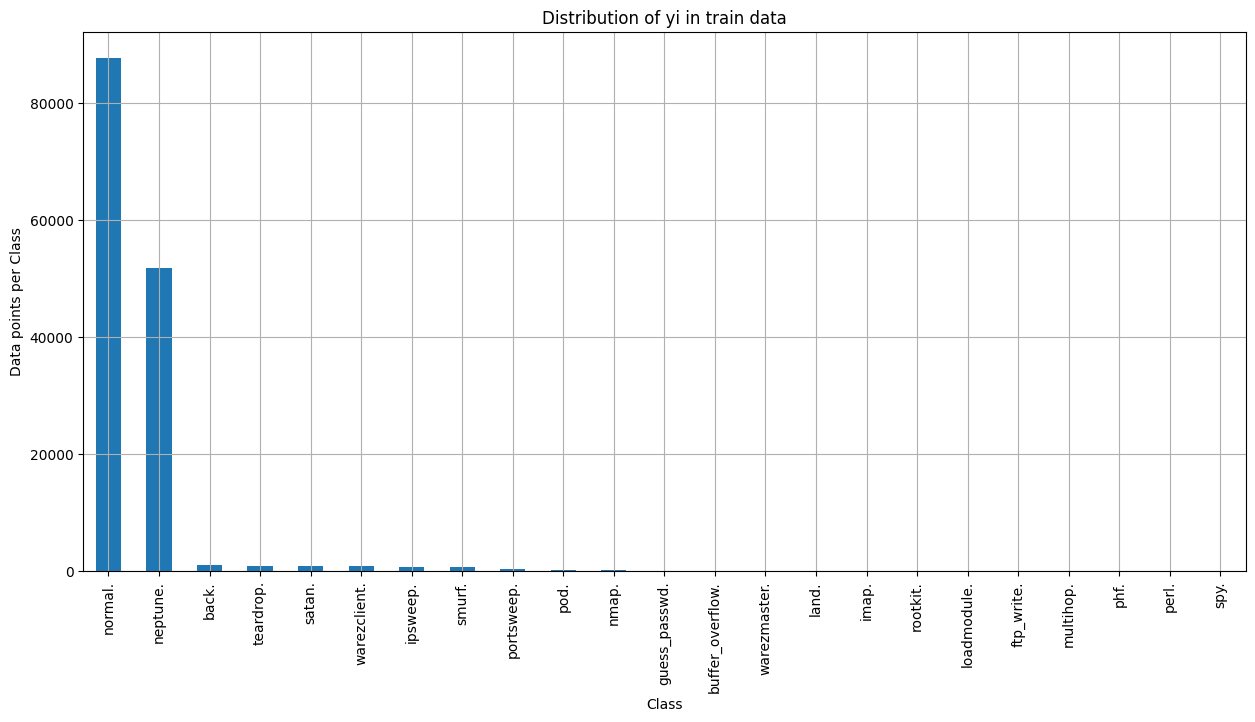

In [5]:
# distribution of the attack categories (outcome)
# Exploratory data analysis
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = pd_data_frame['outcome'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

#normal and neptune are the more prominent classes

In [6]:
# Filter the DataFrame to keep only 'normal.' and 'neptune.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

# Display the head of the new DataFrame
display(filtered_df.head())

# Display the value counts of the 'outcome' column in the new DataFrame to verify the filtering
display(filtered_df.describe())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,88800.000000,8.880000e+04,8.880000e+04,88800.000000,88800.0,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,...,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000
mean,186.876059,1.841420e+03,3.768686e+03,0.000011,0.0,0.000034,0.069662,0.000203,0.794887,0.041340,...,139.716318,202.922106,0.854742,0.045972,0.121897,0.025207,0.002346,0.001192,0.056238,0.054262
std,1313.879378,3.623510e+04,3.931359e+04,0.003356,0.0,0.010067,0.919667,0.021747,0.403786,4.236703,...,102.206888,85.696364,0.294697,0.154868,0.259896,0.049351,0.030791,0.016464,0.220121,0.213595
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.930000e+02,2.250000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,34.000000,166.000000,0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.420000e+02,6.330000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,132.000000,255.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.210000e+02,2.507000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,0.070000,0.030000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# Display the first few rows of the modified DataFrame to verify
print("DataFrame with boolean columns converted to integers:")
display(df_encoded.describe())
print("Columns after nominal attributes encoded: ")
for i in df_encoded.columns:
  print(i)


DataFrame with boolean columns converted to integers:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_red_i,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i
count,88800.000000,8.880000e+04,8.880000e+04,88800.000000,88800.0,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,...,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000,88800.000000
mean,186.876059,1.841420e+03,3.768686e+03,0.000011,0.0,0.000034,0.069662,0.000203,0.794887,0.041340,...,0.000011,0.000011,0.108086,0.000011,0.002466,0.000011,0.000023,0.000394,0.000158,0.004977
std,1313.879378,3.623510e+04,3.931359e+04,0.003356,0.0,0.010067,0.919667,0.021747,0.403786,4.236703,...,0.003356,0.003356,0.310490,0.003356,0.049600,0.003356,0.004746,0.019849,0.012555,0.070376
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.930000e+02,2.250000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.420000e+02,6.330000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.210000e+02,2.507000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Columns after nominal attributes encoded: 
duration
src_bytes
dst_bytes
land
wrong_fragment
urgent
hot
num_failed_logins
logged_in
num_compromised
root_shell
su_attempted
num_root
num_file_creations
num_shells
num_access_files
num_outbound_cmds
is_host_login
is_guest_login
count
srv_count
serror_rate
srv_serror_rate
rerror_rate
srv_rerror_rate
same_srv_rate
diff_srv_rate
srv_diff_host_rate
dst_host_count
dst_host_srv_count
dst_host_same_srv_rate
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
dst_host_serror_rate
dst_host_srv_serror_rate
dst_host_rerror_rate
dst_host_srv_rerror_rate
outcome
flag_OTH
flag_REJ
flag_RSTO
flag_RSTR
flag_S0
flag_S1
flag_S2
flag_S3
flag_SF
protocol_type_icmp
protocol_type_tcp
protocol_type_udp
service_IRC
service_X11
service_auth
service_domain
service_domain_u
service_eco_i
service_ecr_i
service_finger
service_ftp
service_ftp_data
service_http
service_ntp_u
service_other
service_pop_3
service_private
service_red_i
service_shel

# Data Descriptive Analysis

In [8]:

#Lets analyze the data of each category, using common statistic moments

# Create a DataFrame for attacks (attack_detected == 1)
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()

# Create a DataFrame for no attacks (attack_detected == 0)
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()

# Display the first few rows of each new DataFrame to verify
print("DataFrame with attacks:")
display(df_attacks.describe())

print("\nDataFrame with no attacks:")
display(df_no_attacks.describe())



DataFrame with attacks:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_red_i,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i
count,968.000000,968.000000,968.000000,968.0,968.0,968.0,968.000000,968.0,968.0,968.000000,...,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0
mean,0.293388,53666.892562,8129.908058,0.0,0.0,0.0,1.917355,0.0,1.0,0.924587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.660627,4722.463858,919.138524,0.0,0.0,0.0,0.314076,0.0,0.0,0.264193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,13140.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,54540.000000,8314.000000,0.0,0.0,0.0,2.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,54540.000000,8314.000000,0.0,0.0,0.0,2.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,54540.000000,8314.000000,0.0,0.0,0.0,2.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,14.000000,54540.000000,8315.000000,0.0,0.0,0.0,3.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



DataFrame with no attacks:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_red_i,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i
count,87832.000000,8.783200e+04,8.783200e+04,87832.000000,87832.0,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,...,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000,87832.000000
mean,188.932394,1.270249e+03,3.720620e+03,0.000011,0.0,0.000034,0.049299,0.000205,0.792627,0.031606,...,0.000011,0.000011,0.109277,0.000011,0.002493,0.000011,0.000023,0.000398,0.000159,0.005032
std,1320.952947,3.601777e+04,3.952684e+04,0.003374,0.0,0.010123,0.903317,0.021867,0.405427,4.258875,...,0.003374,0.003374,0.311988,0.003374,0.049872,0.003374,0.004772,0.019958,0.012624,0.070761
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.920000e+02,1.930000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.400000e+02,6.120000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.190000e+02,2.431000e+03,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.194619e+06,5.134218e+06,1.000000,0.0,3.000000,30.000000,4.000000,1.000000,884.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Análisis descriptivo de las características en el conjunto

In [9]:
def custom_describe(df):
  # Filtrar solo columnas numéricas
  numeric_df = df.select_dtypes(include='number')
  #Convertir a tensor de PyTorch en GPU o CPU
  tensor = torch.tensor(numeric_df.values, dtype=torch.float32, device=device)


  # Calculo de estadísticas
  mean = tensor.mean(dim=0)
  std = tensor.std(dim=0, unbiased=False)

  def skewness(t):
      mean_ = t.mean(dim=0)
      std_ = t.std(dim=0, unbiased=False)
      skew = (((t - mean_)**3).mean(dim=0)) / (std_**3)
      return skew

  def kurtosis(t):
      mean_ = t.mean(dim=0)
      std_ = t.std(dim=0, unbiased=False)
      kurt = (((t - mean_)**4).mean(dim=0)) / (std_**4)
      return kurt - 3  # Fisher kurtosis (como en pandas)

  skew = skewness(tensor)
  kurt = kurtosis(tensor)

  # Convertir resultados a DataFrame (en CPU)
  custom_describe = pd.DataFrame({
      'mean': mean.cpu().numpy(),
      'std': std.cpu().numpy(),
      'skew': skew.cpu().numpy(),
      'kurtosis': kurt.cpu().numpy()
  }, index=numeric_df.columns)

  # Mostrar resumen
  print(custom_describe)
  return custom_describe

print("Resumen de estadísticas:")
print("Attacks")
describe_attacks = custom_describe(df_attacks)
print("No attacks")
describe_no_attacks = custom_describe(df_no_attacks)



Resumen de estadísticas:
Attacks
                        mean          std      skew   kurtosis
duration            0.293388     1.659769  6.211482  39.397385
src_bytes       53666.890625  4720.023926 -6.385117  42.711460
dst_bytes        8129.907715   918.663696 -5.925030  35.952244
land                0.000000     0.000000       NaN        NaN
wrong_fragment      0.000000     0.000000       NaN        NaN
...                      ...          ...       ...        ...
service_tftp_u      0.000000     0.000000       NaN        NaN
service_tim_i       0.000000     0.000000       NaN        NaN
service_time        0.000000     0.000000       NaN        NaN
service_urh_i       0.000000     0.000000       NaN        NaN
service_urp_i       0.000000     0.000000       NaN        NaN

[75 rows x 4 columns]
No attacks
                       mean           std        skew      kurtosis
duration         188.932388   1320.945435   10.840581    164.946335
src_bytes       1270.249146  36017.558594

 Por cada característica, grafique el histograma para la categoría ataque (backdoor) y normal, y compute la distancia de Jensen-Shannon entre ambas aproximaciones de las densidades. Realice los gráficos para facilitar la comparación, y analice los resultados.

Using device: cuda
Computing moments for 'back.' (attacks)
Computing moments for 'normal.'


,normal_mean,normal_std,normal_skew,normal_kurtosis,back_mean,back_std,back_skew,back_kurtosis
count,8.850578,18.486500,9.788989,142.607300,3.524793,1.761446,2.294673,13.489799
diff_srv_rate,0.017889,0.115963,6.952692,49.552185,0.004587,0.048398,10.946175,123.260406
dst_bytes,3720.620361,39526.617188,70.641769,6579.030762,8129.907715,918.663696,-5.925030,35.952244
dst_host_count,139.642456,102.323669,-0.025722,-1.709484,146.418381,90.679672,-0.056705,-1.559332
dst_host_rerror_rate,0.056157,0.221027,3.890066,13.396589,0.063564,0.109976,4.967799,32.017109
dst_host_same_src_port_rate,0.122985,0.260983,2.556263,5.319405,0.023202,0.078852,9.212126,101.265213
dst_host_serror_rate,0.002349,0.030954,23.756382,625.251831,0.002035,0.005501,3.190155,11.172428
dst_host_srv_count,203.544830,85.431389,-1.390796,0.346068,146.418381,90.679672,-0.056705,-1.559332
dst_host_srv_rerror_rate,0.054160,0.214455,3.889679,13.448929,0.063564,0.109976,4.967799,32.017109
dst_host_srv_serror_rate,0.001183,0.016544,43.772030,2172.992188,0.002035,0.005501,3.190155,11.172428


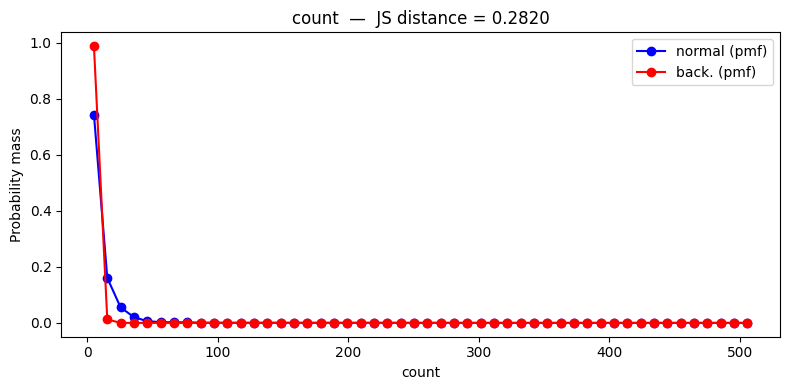

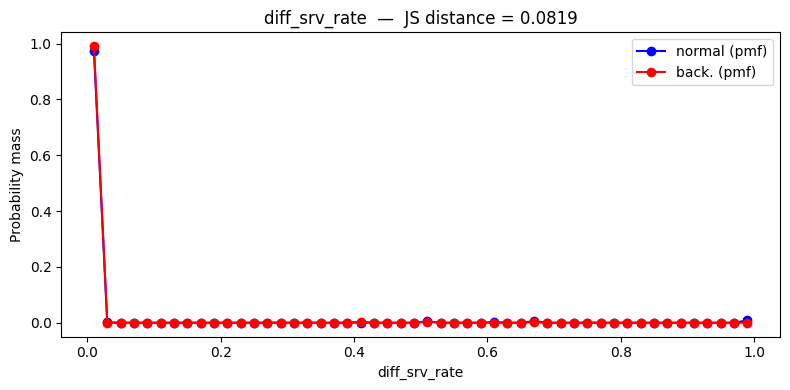

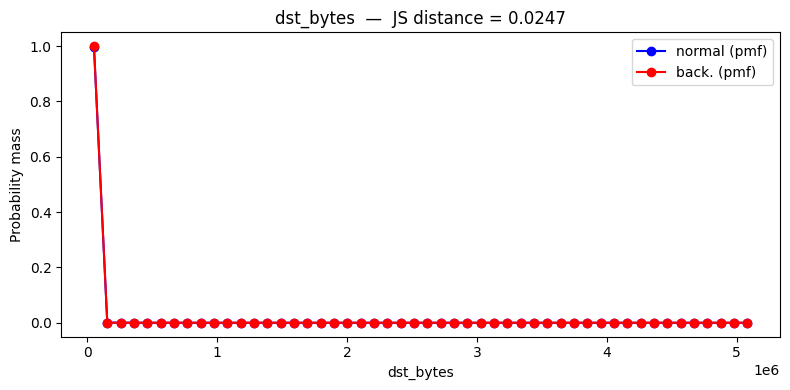

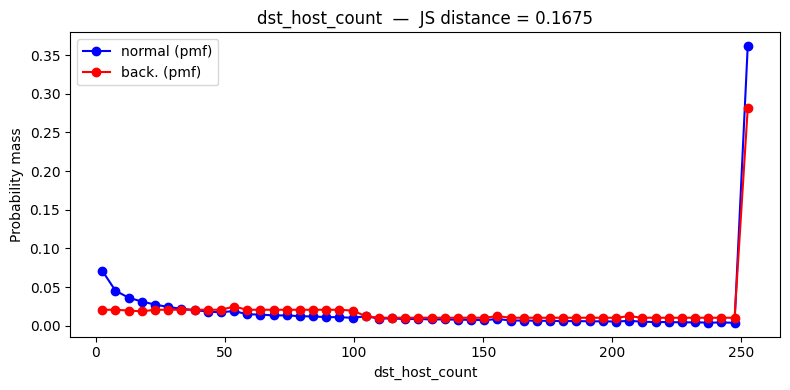

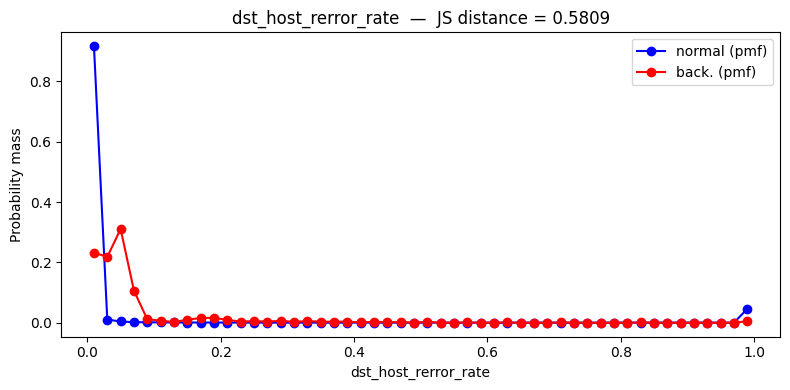

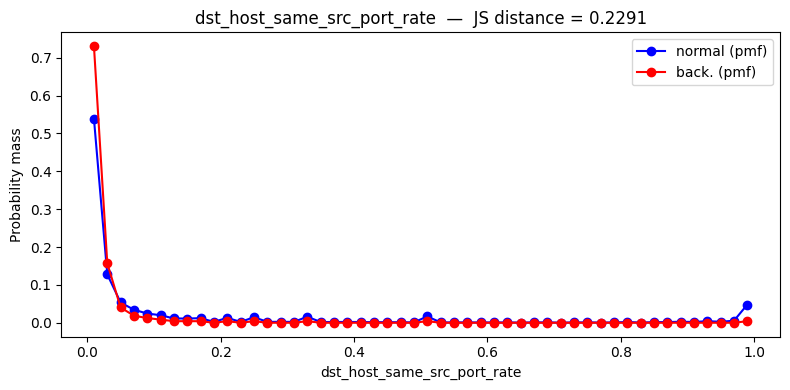

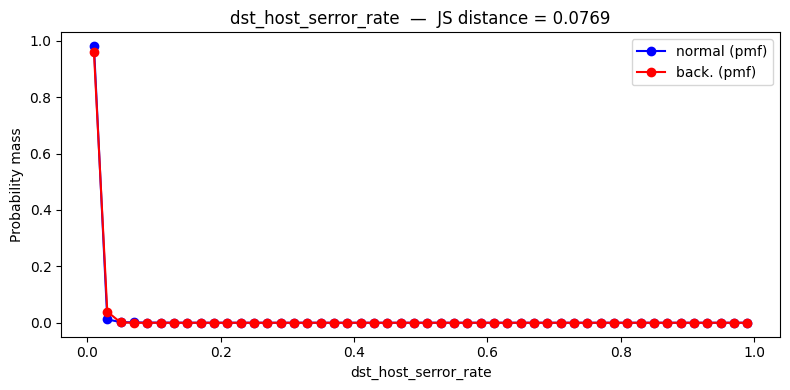

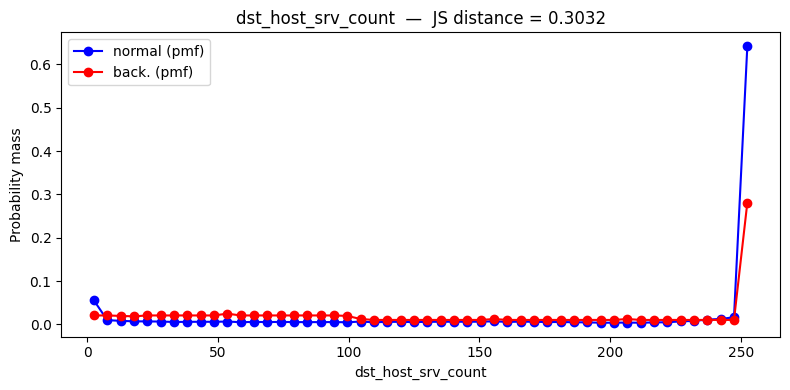

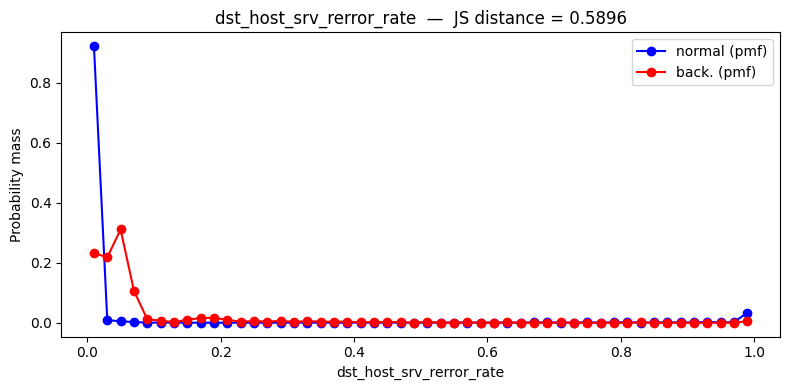

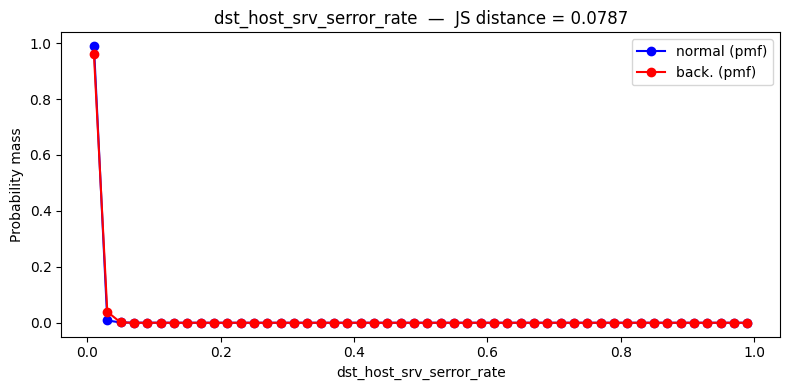

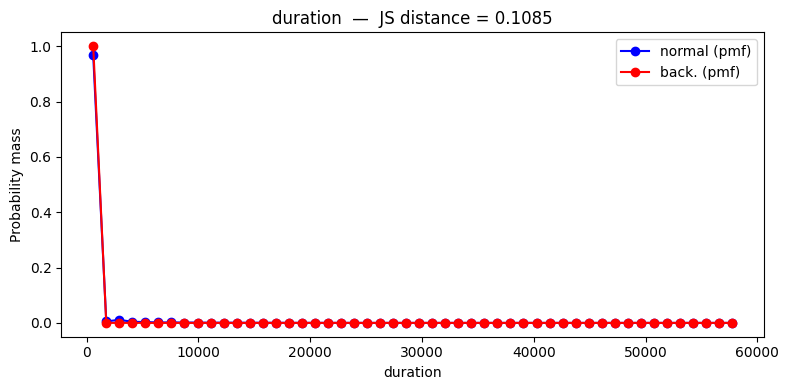

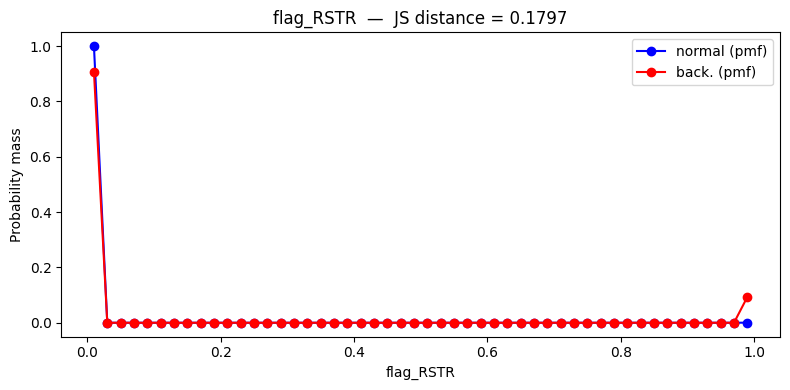

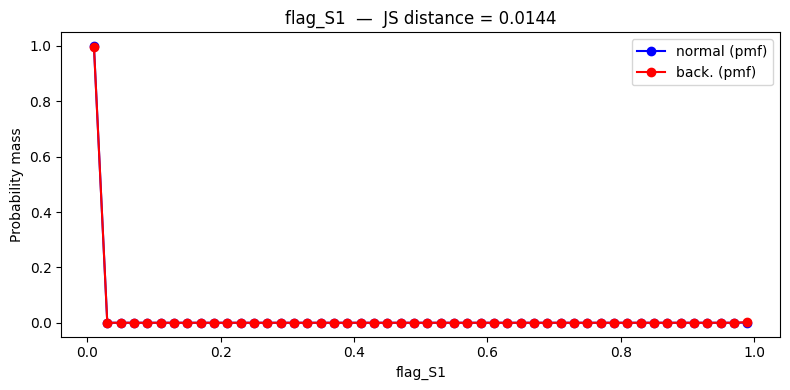

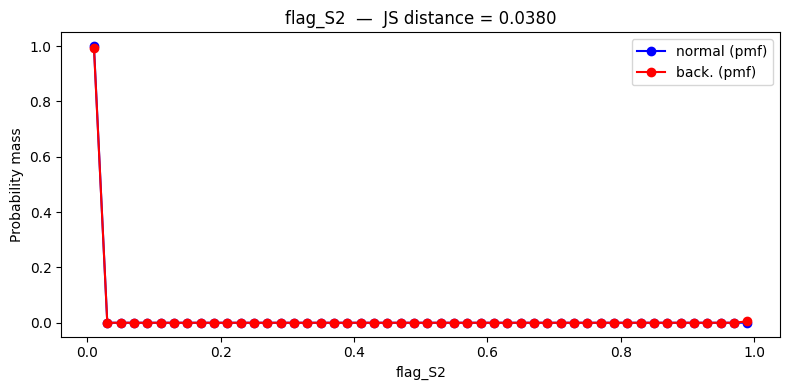

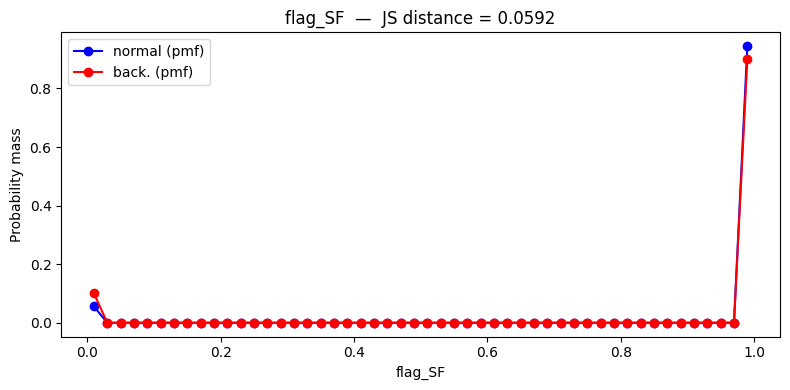

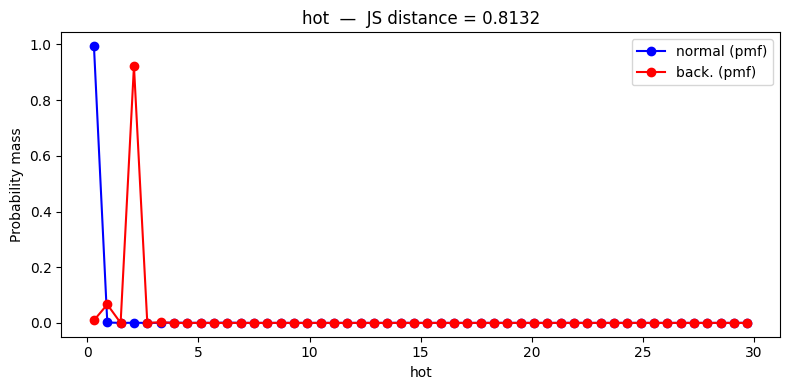

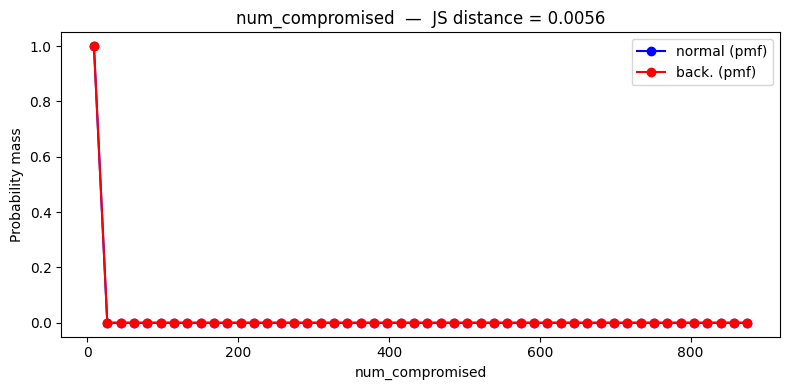

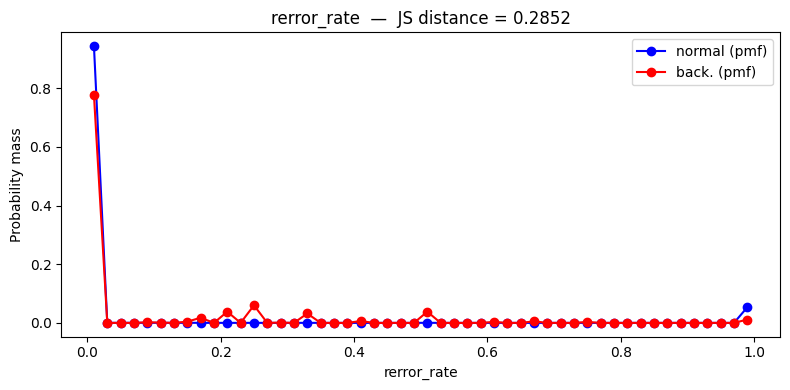

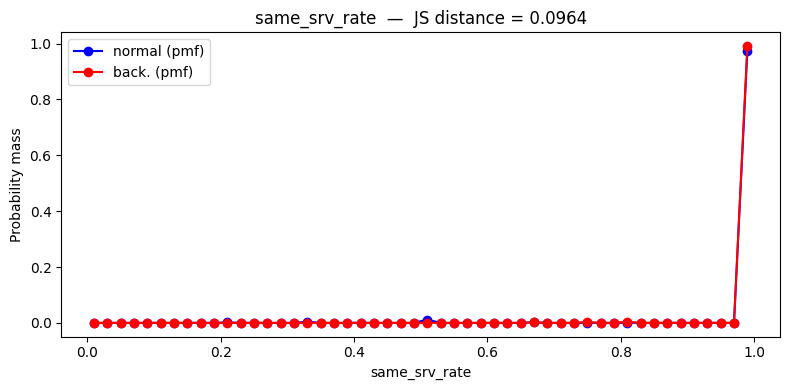

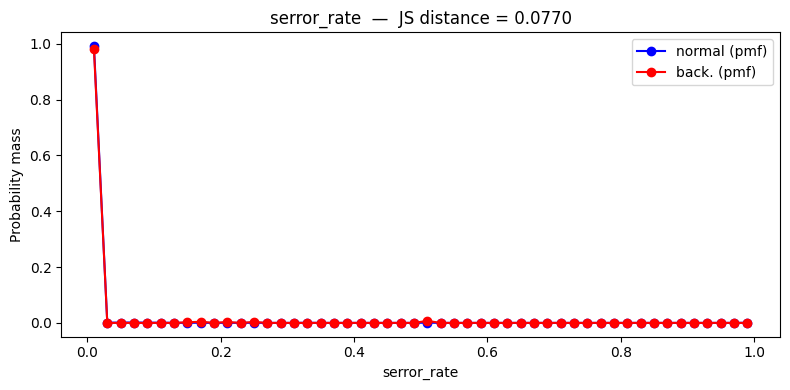

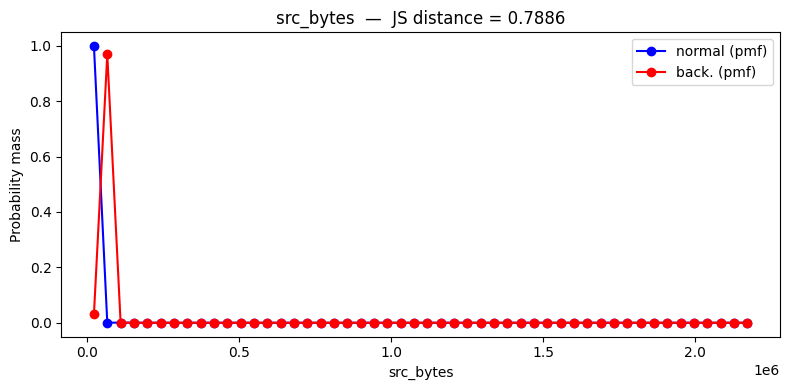

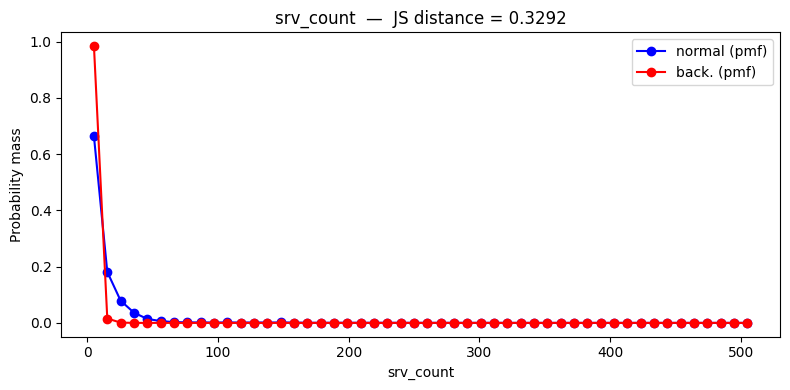

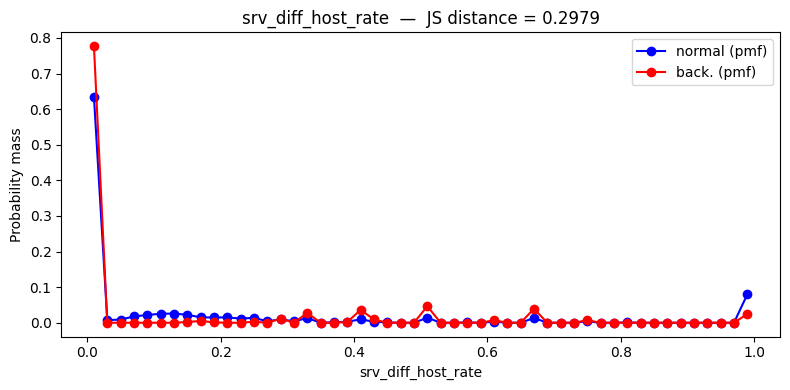

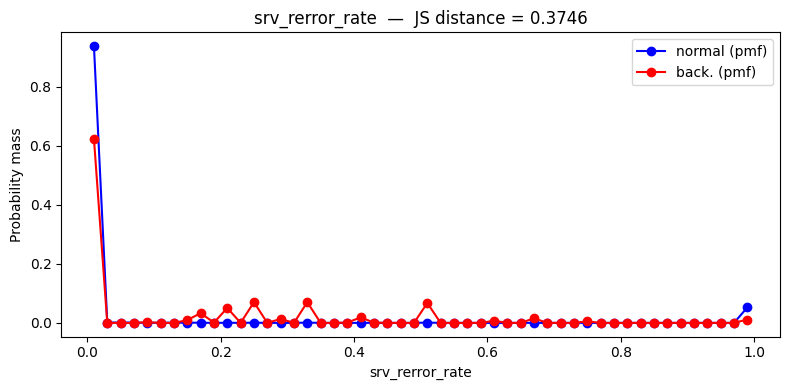

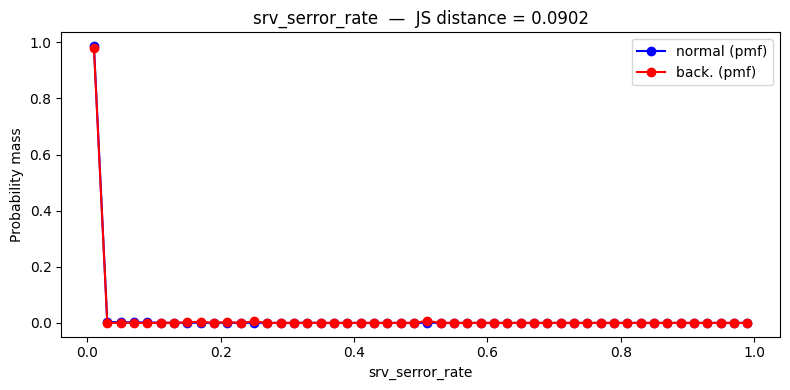

,0
hot,0.813179
src_bytes,0.788602
dst_host_srv_rerror_rate,0.589621
dst_host_rerror_rate,0.580869
srv_rerror_rate,0.374571
srv_count,0.329243
dst_host_srv_count,0.303169
srv_diff_host_rate,0.297912
rerror_rate,0.285151
count,0.282032


In [10]:
# --- PyTorch-based moments + proper JS histograms ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.stats import entropy
from math import sqrt

# assume df_encoded exists from your previous steps and filtered_df kept only 'normal.' and 'back.' outcomes
# Also assume df_attacks = df_encoded[df_encoded['outcome']=='back.'] ; df_no_attacks = df_encoded[df_encoded['outcome']=='normal.']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Helper: get numeric columns (exclude outcome)
def get_numeric_df(df):
    numeric = df.select_dtypes(include=[np.number]).copy()
    # remove columns that are constant (zero variance)
    numeric = numeric.loc[:, numeric.nunique() > 1]
    return numeric

num_attacks = get_numeric_df(df_attacks)
num_normal  = get_numeric_df(df_no_attacks)

# Ensure same numeric columns in both (intersection)
common_cols = sorted(list(set(num_attacks.columns).intersection(set(num_normal.columns))))
num_attacks = num_attacks[common_cols]
num_normal  = num_normal[common_cols]

# 1) PyTorch moments computation
def compute_moments_torch(df_num: pd.DataFrame):
    t = torch.tensor(df_num.values, dtype=torch.float32, device=device)  # shape (n_samples, n_features)
    mean = t.mean(dim=0)
    std  = t.std(dim=0, unbiased=False)
    # skewness and kurtosis (Fisher)
    m = mean
    s = std
    # avoid divide-by-zero for constant cols (shouldn't be present after filtering)
    skew = (((t - m)**3).mean(dim=0)) / (s**3 + 1e-20)
    kurt = (((t - m)**4).mean(dim=0)) / (s**4 + 1e-20) - 3.0
    df_stats = pd.DataFrame({
        'mean': mean.cpu().numpy(),
        'std': std.cpu().numpy(),
        'skew': skew.cpu().numpy(),
        'kurtosis': kurt.cpu().numpy()
    }, index=df_num.columns)
    return df_stats

print("Computing moments for 'back.' (attacks)")
mom_back = compute_moments_torch(num_attacks)
print("Computing moments for 'normal.'")
mom_norm = compute_moments_torch(num_normal)

# Combine into one compact table for comparison
mom_compare = pd.concat(
    [mom_norm.add_prefix('normal_'), mom_back.add_prefix('back_')],
    axis=1
)
display(mom_compare)

# 2) Histograms + Jensen-Shannon distances
def jensen_shannon(p, q):
    # p, q are numpy arrays with positive values summing to 1
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    # Ensure normalization
    p = p / (p.sum() + 1e-20)
    q = q / (q.sum() + 1e-20)
    m = 0.5 * (p + q)
    # KL divergence base e; JS divergence = 0.5 KL(p||m) + 0.5 KL(q||m)
    js = 0.5 * (entropy(p, m) + entropy(q, m))
    return sqrt(js)  # returns Jensen-Shannon distance (sqrt of divergence)

js_results = {}

# choose number of bins
NBINS = 50

for col in common_cols:
    a = num_normal[col].dropna().values
    b = num_attacks[col].dropna().values
    if a.size < 2 or b.size < 2:
        js_results[col] = np.nan
        continue

    # compute shared bins using combined data range
    try:
        all_min = min(a.min(), b.min())
        all_max = max(a.max(), b.max())
    except:
        all_min = 0.0
        all_max = 1.0

    if all_min == all_max:
        # degenerate, skip
        js_results[col] = 0.0
        continue

    bins = np.linspace(all_min, all_max, NBINS + 1)

    # histogram counts (not density). Use same bins for both
    cnt_a, _ = np.histogram(a, bins=bins, density=False)
    cnt_b, _ = np.histogram(b, bins=bins, density=False)

    # convert counts -> probability mass (sum=1)
    pmf_a = cnt_a.astype(np.float64) / (cnt_a.sum() + 1e-20)
    pmf_b = cnt_b.astype(np.float64) / (cnt_b.sum() + 1e-20)

    # numerically stable: add small epsilon so no zero probs (optional)
    eps = 1e-12
    pmf_a += eps
    pmf_b += eps
    pmf_a /= pmf_a.sum()
    pmf_b /= pmf_b.sum()

    jsd = jensen_shannon(pmf_a, pmf_b)
    js_results[col] = jsd

   # Plot overlayed line plots instead
    plt.figure(figsize=(8,4))
    centers = (bins[:-1] + bins[1:]) / 2.0

    plt.plot(centers, pmf_a, marker='o', color='blue', label='normal (pmf)')
    plt.plot(centers, pmf_b, marker='o', color='red', label='back. (pmf)')

    plt.title(f"{col}  —  JS distance = {jsd:.4f}")
    plt.xlabel(col)
    plt.ylabel('Probability mass')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Present JS summary sorted by distance
js_series = pd.Series(js_results).sort_values(ascending=False)
display(js_series.head(30))  # top features by JS distance
